<a href="https://colab.research.google.com/github/mjn6862/Freiburg_dataset/blob/master/Matthew_Copy_of_Warping_for_PoseNet_Freiburg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Statements**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow_graphics

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_graphics.geometry.transformation as tfg_transformation
from tensorflow import keras
from datetime import datetime
import csv
from matplotlib import pyplot as plt
tf.keras.backend.set_floatx('float64')

**Custom Data Generator**

This works (I think) for giving two sequential images to a Keras Functional model as well as the velocity associated with the second image.

At this point, don't worry about how this works. If you need something changed or fixed, just ask. This is the boring part anyways.

In [3]:
# Define hx, wx, h1 as the homogeneous pixel coordinates
# This appears to match the original paper's output format
height_coord = range(480)
width_coord = range(640)
hx, wx = pixel_coord = np.meshgrid(height_coord, width_coord, indexing='ij')
hx = hx.reshape((480, 640, 1))
wx = wx.reshape((480, 640, 1))
h1 = np.ones(hx.shape)

grid = np.concatenate((hx, wx, h1), axis=-1)

# Define the camera intrinsic matrix
#K = np.array([[525.,0.,319.5], [0., 525., 239.5], [0.,0.,1.]])  # This is how the rostopic defines it
K = np.array([[525.,0.,239.5], [0., 525., 319.5], [0.,0.,1.]])

# Define the camera coordinates of each piel up to a depth scale factor
unscaled_cam_coord = np.empty(grid.shape)
for i in range(480):
      for j in range(640):
        unscaled_cam_coord[i,j,:]= np.linalg.inv(K).dot(grid[i,j,:])

In [4]:
def warp_image(image1, depth1, delta_pose):
  # This function takes an image and depth map and predicts the view after a transformation by delta_pose
  # What would image1 taken at the location after delta_pose look like? Should match image2
  [N, H, W, C] = image1.shape
  new_image = np.empty(image1.shape)
  for n in range(N):
    camera_coord = depth1[n,:,:].reshape((307200, 1))*unscaled_cam_coord.reshape(307200, 3)
    homog_camera_coord = np.concatenate( (camera_coord, np.ones((307200, 1)) ), axis=1 )


    new_homog_camera_coord = np.empty(homog_camera_coord.shape)
    new_pixel_coord = np.empty((307200, 3))
    pixel_list = np.empty((307200,2))
    for i in range(307200):
      new_homog_camera_coord[i, :] = delta_pose[n,:,:].dot(homog_camera_coord[i, :])
      new_homog_camera_coord[i, :] = new_homog_camera_coord[i, :]/new_homog_camera_coord[i, 2]
      pixel_list[i, :] = K.dot(new_homog_camera_coord[i,0:3])[0:2]

    new_image[n, :, :, :] = tf.reshape(tfa.image.interpolate_bilinear(grid=image1[n,:,:,:].reshape((1, 480, 640, 3)), query_points=pixel_list.reshape((1, 307200,2)) ), (480, 640, 3))
  return new_image

In [5]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, custom_indices, batch_size=32,
                  shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.direct = "./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/"
        self.indexes = custom_indices
        self.save_indices = custom_indices
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        index = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Find list of IDs
        # Generate data
        X, y = self.__data_generation(index)#batch)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = self.save_indices #np.arange(len(self.list_IDs)-5)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, names_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        x1_full = np.empty((0, 480, 640, 4))
        x2_full = np.empty((0, 480, 640, 4))
        y_full = np.empty((0, 4, 4))
        for name in names_temp:
          # Small hack due to off-by-one in the inidices
          x1 = np.load(self.direct+"/images/rgbd_%d.npy"%int(self.list_IDs[int(name[0])][0]))
          #print("%d, %d" %(int(self.list_IDs[int(name[0])][0]), int(self.list_IDs[int(name[0])+4][0])))
          x1 = np.reshape(x1,(1,480, 640, 4))
          x2 = np.load(self.direct+"images/rgbd_%d.npy"%int(self.list_IDs[int(name[0])+4][0]))
          x2 = np.reshape(x2,(1,480, 640, 4))
          x1 = x1/255.
          #x1 = x1 - np.mean(x1, axis=0)
          x2 = x2/255.
          #x2 = x2 - np.mean(x2, axis=0)
          depth1 = x1[0,:,:,3]*5.
          depth1 = np.where(depth1==0,10.,depth1)
          depth2 = x2[0,:,:,3]*5
          depth2 = np.where(depth2==0,10.,depth2)
          x1[0,:,:,3] = depth1
          x2[0,:,:,3] = depth2
          y1 = np.load(self.direct+"pose/htm_%d.npy"%int(self.list_IDs[int(name[0])][0]))
          y2 = np.load(self.direct+"pose/htm_%d.npy"%int(self.list_IDs[int(name[0])+4][0]))
          #y = np.linalg.inv(y1).dot(y2) # Use this if the poses are camera in world frame
          #y = y1.dot(np.linalg.inv(y2)) # Use this if the poses are world in camera frame
          x1_full = np.concatenate((x1_full, x1))
          x2_full = np.concatenate((x2_full, x2))
          #y_full = np.concatenate((y_full, np.reshape(y, (1, 4, 4)) ))
        #y_quat = tfg_transformation.quaternion.from_rotation_matrix(y_full[:,0:3, 0:3])
        #y_quat = np.arccos(y_quat[:,3]).reshape((-1,1))*y_quat[:,0:3]/np.linalg.norm(y_quat[:,0:3], axis=1).reshape((-1,1))
        #total = tf.keras.layers.concatenate((y_quat, y_full[:,0:3,3]), dtype='float64')
        # here
        return  [x1_full[:,:,:,0:3], x1_full[:,:,:,3], x2_full[:,:,:,0:3], x2_full[:,:,:,3]],[x2_full[:,:,:,0:3]]

**Define the test-train split and create the Data Generator**

In [6]:
def make_generator(indices_filename):
  with open('./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/all_frame_ids.csv', newline='') as f:
    reader = csv.reader(f)
    list_IDs = list(reader)
  with open(indices_filename, newline='') as f:
    reader = csv.reader(f)
    indices = list(reader)
  indices = np.asarray(indices)
  return DataGenerator(list_IDs = list_IDs, custom_indices = indices, batch_size=16, shuffle=True )

In [7]:
train_filename = './drive/My Drive/Machine_Learning_Projects/freiburg_dataset/training_indices.csv'
valid_filename = './drive/My Drive/Machine_Learning_Projects/freiburg_dataset/validation_indices.csv'

training_generator = make_generator(train_filename)
validation_generator = make_generator(valid_filename)

In [14]:
class DataGeneratorWarp(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, custom_indices, batch_size=32,
                  shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.direct = "./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/"
        self.indexes = custom_indices
        self.save_indices = custom_indices
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        index = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Find list of IDs
        # Generate data
        X, y = self.__data_generation(index)#batch)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = self.save_indices #np.arange(len(self.list_IDs)-5)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, names_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        x1_full = np.empty((0, 480, 640, 4))
        x2_full = np.empty((0, 480, 640, 4))
        y_full = np.empty((0, 4, 4))
        for name in names_temp:
          # Small hack due to off-by-one in the inidices
          x1 = np.load(self.direct+"/images/rgbd_%d.npy"%int(self.list_IDs[int(name[0])][0]))
          #print("%d, %d" %(int(self.list_IDs[int(name[0])][0]), int(self.list_IDs[int(name[0])+4][0])))
          x1 = np.reshape(x1,(1,480, 640, 4))
          x2 = np.load(self.direct+"images/rgbd_%d.npy"%int(self.list_IDs[int(name[0])+4][0]))
          x2 = np.reshape(x2,(1,480, 640, 4))
          x1 = x1/255.
          #x1 = x1 - np.mean(x1, axis=0)
          x2 = x2/255.
          #x2 = x2 - np.mean(x2, axis=0)
          depth1 = x1[0,:,:,3]*5.
          depth1 = np.where(depth1==0,10.,depth1)
          depth2 = x2[0,:,:,3]*5
          depth2 = np.where(depth2==0,10.,depth2)
          x1[0,:,:,3] = depth1
          x2[0,:,:,3] = depth2
          y1 = np.load(self.direct+"pose/htm_%d.npy"%int(self.list_IDs[int(name[0])][0]))
          y2 = np.load(self.direct+"pose/htm_%d.npy"%int(self.list_IDs[int(name[0])+4][0]))
          #y = np.linalg.inv(y1).dot(y2) # Use this if the poses are camera in world frame
          y = y1.dot(np.linalg.inv(y2)) # Use this if the poses are world in camera frame
          x1_full = np.concatenate((x1_full, x1))
          x2_full = np.concatenate((x2_full, x2))
          y_full = np.concatenate((y_full, np.reshape(y, (1, 4, 4)) ))
        #y_quat = tfg_transformation.quaternion.from_rotation_matrix(y_full[:,0:3, 0:3])
        #y_quat = np.arccos(y_quat[:,3]).reshape((-1,1))*y_quat[:,0:3]/np.linalg.norm(y_quat[:,0:3], axis=1).reshape((-1,1))
        #total = tf.keras.layers.concatenate((y_quat, y_full[:,0:3,3]), dtype='float64')
        # here
        new_image = warp_image(x1_full[:,:,:,0:3],x1_full[:,:,:,3],y_full)
        return  [x1_full[:,:,:,0:3], x1_full[:,:,:,3], x2_full[:,:,:,0:3], x2_full[:,:,:,3]],[new_image]

In [15]:
def make_generator_warp(indices_filename):
  with open('./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/all_frame_ids.csv', newline='') as f:
    reader = csv.reader(f)
    list_IDs = list(reader)
  with open(indices_filename, newline='') as f:
    reader = csv.reader(f)
    indices = list(reader)
  indices = np.asarray(indices)
  return DataGeneratorWarp(list_IDs = list_IDs, custom_indices = indices, batch_size=16, shuffle=True )

In [16]:
train_filename = './drive/My Drive/Machine_Learning_Projects/freiburg_dataset/training_indices.csv'
valid_filename = './drive/My Drive/Machine_Learning_Projects/freiburg_dataset/validation_indices.csv'

training_generator_warp = make_generator_warp(train_filename)
validation_generator_warp = make_generator_warp(valid_filename)

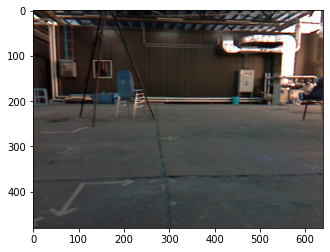

In [10]:
plt.imshow(training_generator[1][1][0][0])

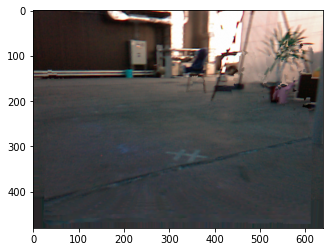

In [17]:
plt.imshow(validation_generator_warp[0][1][0][15])

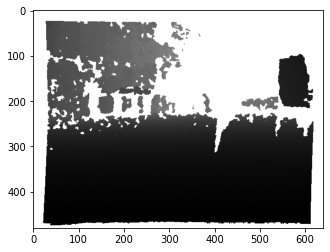

In [ ]:
plt.imshow(training_generator[1][0][3][0],cmap='gray')

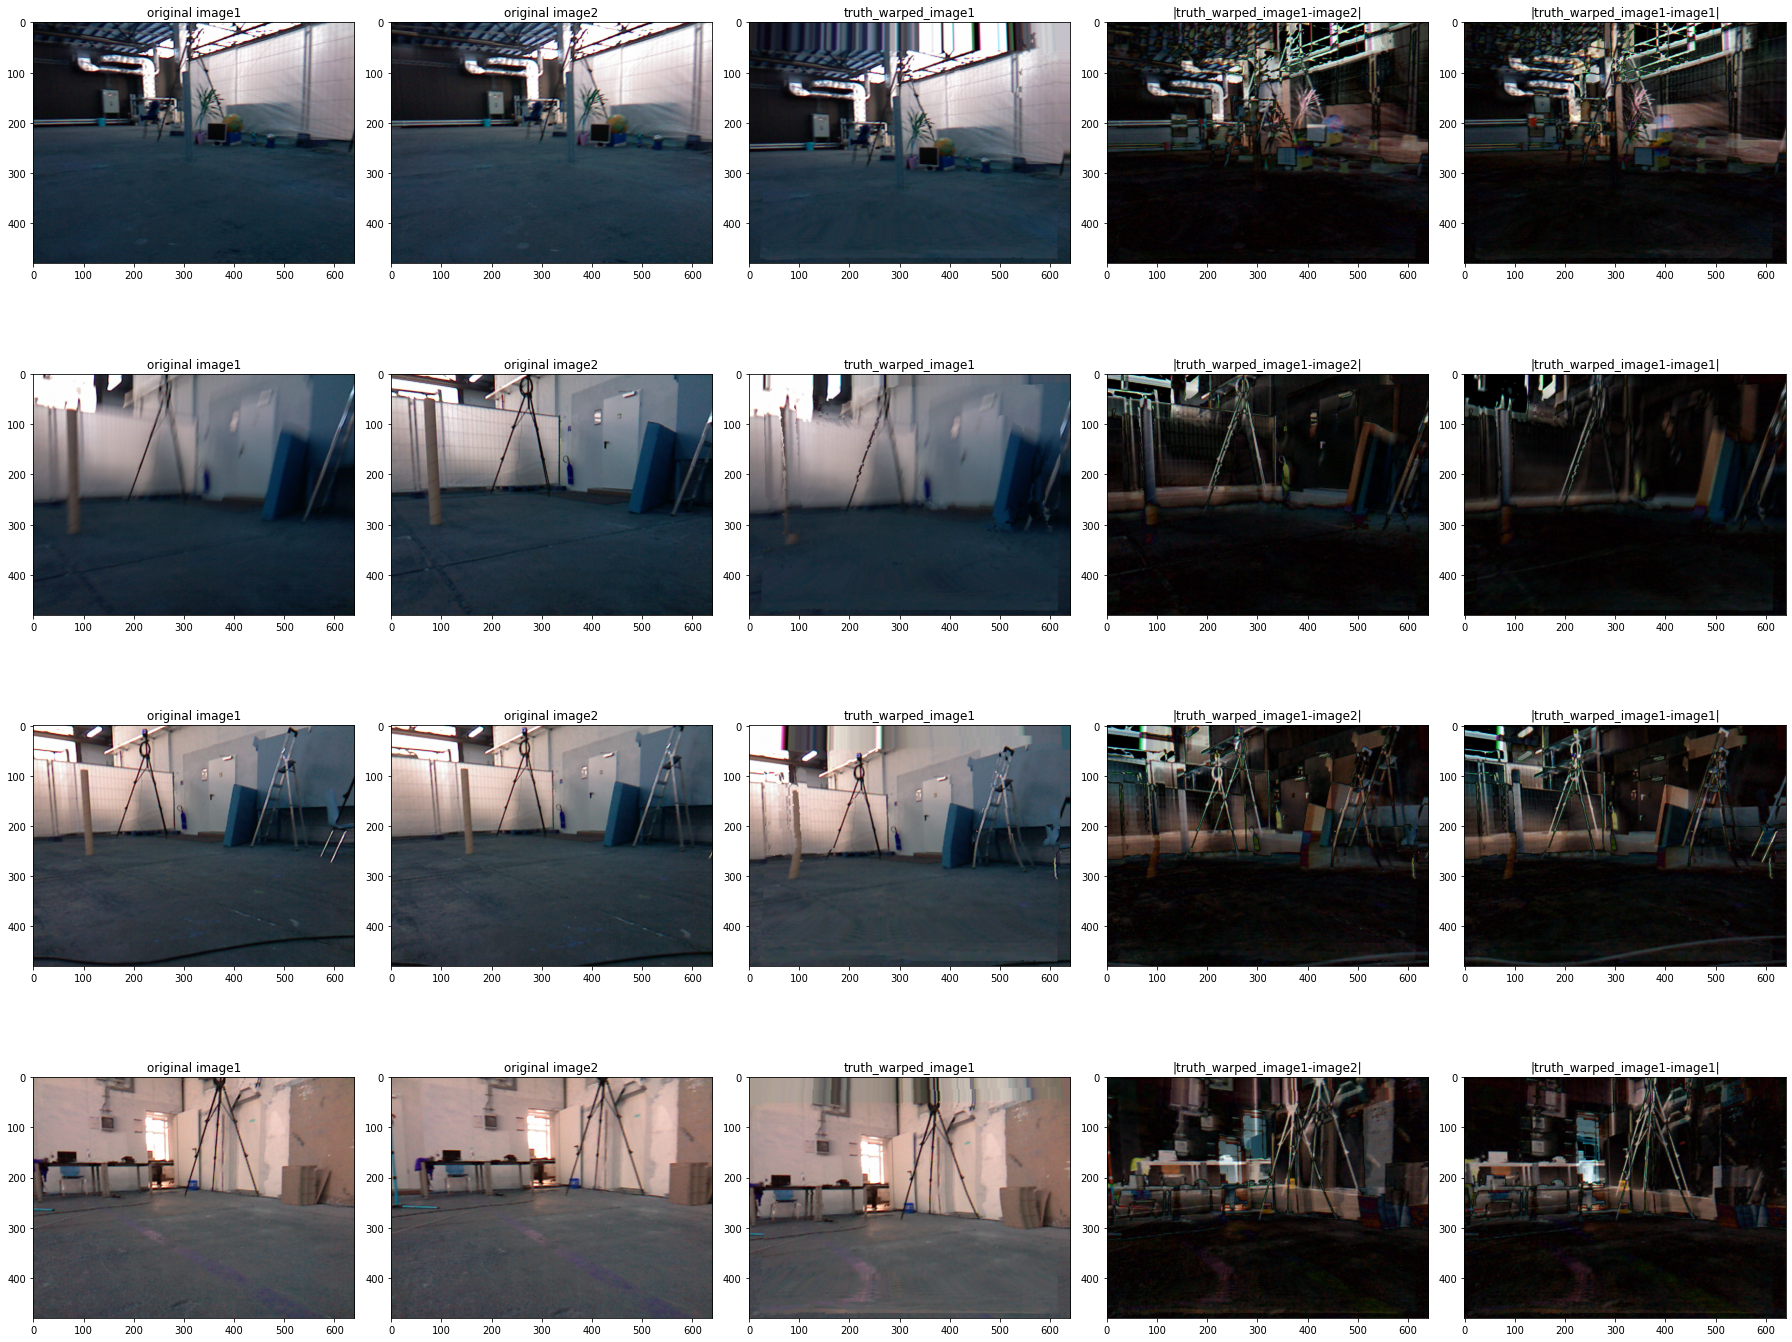

In [18]:
# Let's visualize some truth warps

# pick some random batches
m = 4
pick_batch = np.random.choice(np.arange(0,14,1),size=m,replace=True)
pick_image = np.random.choice(np.arange(0,16,1),size=m,replace=True)

plt.figure(figsize=(25,m*5))

for i in range(m):
  plt.subplot(m,5,i*5+1)
  image1 = validation_generator_warp[pick_batch[i]][0][0][pick_image[i]]
  plt.imshow(image1)
  plt.title('original image1')
  plt.subplot(m,5,i*5+2)
  image2 = validation_generator_warp[pick_batch[i]][0][2][pick_image[i]]
  plt.imshow(image2)
  plt.title('original image2')
  plt.subplot(m,5,i*5+3)
  truth_warp = validation_generator_warp[pick_batch[i]][1][0][pick_image[i]]
  plt.imshow(truth_warp)
  plt.title('truth_warped_image1')
  plt.subplot(m,5,i*5+4)
  plt.imshow(np.abs(truth_warp-image2))
  plt.title('|truth_warped_image1-image2|')
  plt.subplot(m,5,i*5+5)
  plt.imshow(np.abs(truth_warp-image1))
  plt.title('|truth_warped_image1-image1|')
plt.tight_layout()
plt.show()

In [19]:
input_A = tf.keras.layers.Input(shape=(480, 640, 3), name="first_image")
depth_A = tf.keras.layers.Input(shape=(480, 640, 1), name="first_depth")
input_B = tf.keras.layers.Input(shape=(480, 640, 3), name="second_image")
depth_B = tf.keras.layers.Input(shape=(480, 640, 1), name="second_depth")

In [20]:
#conv_A = tf.keras.layers.Conv2D(16,(7, 7), padding='same', strides=(2, 2), activation='relu',name='conv_A')(input_A)
#conv_dA = tf.keras.layers.Conv2D(16,(7, 7), padding='same', strides=(2, 2), activation='relu',name='conv_dA')(depth_A)
#conv_B = tf.keras.layers.Conv2D(16,(7, 7), padding='same', strides=(2, 2), activation='relu',name='conv_B')(input_B)
#conv_dB = tf.keras.layers.Conv2D(16,(7, 7), padding='same', strides=(2, 2), activation='relu',name='conv_dB')(depth_B)

In [21]:
#out_dim = 6
#concat = tf.keras.layers.concatenate([conv_A, conv_dA, conv_B,conv_dB],name='concat')
#conv1 = tf.keras.layers.Conv2D(16,(7, 7), padding='same', strides=(2, 2), activation='relu',name='conv1')(concat)
#conv2 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', strides=(2, 2), activation='relu',name='conv2')(conv1)
#conv3 = tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu', name='conv3')(concat)
#readout = tf.keras.layers.Conv2D(out_dim, (1, 1),name='readout')(conv3)
#readout2 = tf.keras.layers.GlobalAveragePooling2D(name='readout2')(readout)
#input_pose = tf.keras.layers.Flatten(name='input_pose')(readout2)

In [22]:
out_dim = 6
concat = tf.keras.layers.concatenate([input_A, input_B],name='concat')
conv1 = tf.keras.layers.Conv2D(16,(7, 7), padding='same', strides=(2, 2), activation='relu',name='conv1')(concat)
conv2 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', strides=(2, 2), activation='relu',name='conv2')(conv1)
readout = tf.keras.layers.Conv2D(out_dim, (1, 1),name='readout')(conv2)
readout2 = tf.keras.layers.GlobalAveragePooling2D(name='readout2')(readout)
input_pose = tf.keras.layers.Flatten(name='input_pose')(readout2)

In [23]:
def exp_mat(xi):
  '''
  Takes an xi = [omega nu] and returns the corresponding homogeneous
  transformation matrix, within a tf.keras model.
  inputs:
    xi: a (None,6) tensor output from a layer of a tf.keras model
  outputs:
    exp_xi: a (None,4,4) tensor output from a layer of a tf.keras model
  '''
  # create 3x3 matrix omega_x from xi=[omega nu]
  omega_x_weights = np.zeros([6,9])
  omega_x_weights[0,5]=-1
  omega_x_weights[0,7]=1
  omega_x_weights[1,2]=1
  omega_x_weights[1,6]=-1
  omega_x_weights[2,1]=-1
  omega_x_weights[2,3]=1

  omega_x = tf.keras.layers.Dense(9,use_bias=False,weights=[omega_x_weights],trainable=False,name='omega_x1')(xi)
  omega_x = tf.keras.layers.Reshape((3,3),name='omega_x2')(omega_x)

  # create 3-dimensional vector nu from xi=[omega nu]
  nu_weights = np.zeros([6,3])
  nu_weights[3,0]=1
  nu_weights[4,1]=1
  nu_weights[5,2]=1

  nu = tf.keras.layers.Dense(3,use_bias=False,weights=[nu_weights],trainable=False,name='nu1')(xi)
  nu = tf.keras.layers.Reshape((3,1),name='nu2')(nu)

  xi_hat = tf.keras.layers.concatenate([omega_x,nu],name='xi_hat_concat')
  xi_hat = tf.keras.layers.ZeroPadding1D(padding=(0,1),name='xi_hat_bottom_row')(xi_hat)
  exp_xi = tf.keras.layers.Lambda(tf.linalg.expm,name='exp_xi')(xi_hat)
  return exp_xi

In [24]:
# Define hx, wx, h1 as the homogeneous pixel coordinates
# This appears to match the original paper's output format
height_coord = range(480)
width_coord = range(640)
hx, wx = pixel_coord = np.meshgrid(height_coord, width_coord, indexing='ij')
hx = hx.reshape((480, 640, 1))
wx = wx.reshape((480, 640, 1))
h1 = np.ones(hx.shape)

grid = np.concatenate((hx, wx, h1), axis=-1)

# Define the camera intrinsic matrix
#K = np.array([[525.,0.,319.5], [0., 525., 239.5], [0.,0.,1.]])  # This is how the rostopic defines it
K = np.array([[525.,0.,239.5], [0., 525., 319.5], [0.,0.,1.]])

# Define the camera coordinates of each piel up to a depth scale factor
unscaled_cam_coord = np.empty(grid.shape)
for i in range(480):
      for j in range(640):
        unscaled_cam_coord[i,j,:]= np.linalg.inv(K).dot(grid[i,j,:])

In [25]:
def warp_image(image1,depth1,htm):
  '''
  Use an htm and depth1 to warp image1 in a keras model.
  inputs:
    image1: a (None,480,640,3) tensor
    depth1: a (None,480,640,1) tensor
    htm: a (None,4,4) tensor
  output:
    new_image: a (None,480,640,3) tensor
  '''
  camera_coord = tf.keras.layers.Reshape((307200,1),name='camera_coord1')(depth1)
  def camera_coord_fun(depth):
    return depth*unscaled_cam_coord.reshape(307200,3)
    
  camera_coord = tf.keras.layers.Lambda(camera_coord_fun,name='camera_coord2')(camera_coord)

  # Here's an annoying way to get an output of all ones.  Just take a matrix of the appropriate size to the power zero element-wise
  ones_layer = tf.keras.layers.Flatten(name='ones1')(depth1)
  def ones_fun(depth):
    return tf.math.pow(depth,0)
  ones_layer = tf.keras.layers.Lambda(ones_fun,name='ones2')(ones_layer)
  ones_layer = tf.keras.layers.Reshape((307200,1),name='ones3')(ones_layer)

  homog_camera_coord = tf.keras.layers.concatenate([camera_coord, ones_layer],name='homog_camera_coord')

  # new_homog_camera_coord = tf.keras.backend.dot(homog_camera_coord, tf.keras.backend.transpose(tf.reshape(delta_pose,(4,4))))
  # new_homog_camera_coord = tf.math.divide(new_homog_camera_coord, tf.reshape(new_homog_camera_coord[:,2], (307200,1)) ) 
  new_homog_camera_coord = tf.keras.layers.Dot(axes=(2,2),name='new_homog_camera_coord1')([homog_camera_coord,htm]) # not sure if axes value is correct, but the output has all ones on the right side, so it's probably right

  new_coord_depth1 = tf.keras.layers.Lambda(lambda coord: coord[:,:,2],name='new_coord_depth1')(new_homog_camera_coord)
  new_coord_depth2 = tf.keras.layers.Reshape((307200,1),name='new_coord_depth2')(new_coord_depth1)
  def new_homog_camera_coord_fun(x):
    return tf.math.divide(x[0],x[1])
  new_homog_camera_coord = tf.keras.layers.Lambda(new_homog_camera_coord_fun,name='new_homog_camera_coord2')((new_homog_camera_coord,new_coord_depth2))
  new_homog_camera_coord = tf.keras.layers.Lambda(lambda coord: coord[:,:,0:3],name='new_homog_camera_coord3')(new_homog_camera_coord)

  #  pixel_list = tf.keras.backend.dot(tf.reshape(new_homog_camera_coord[:,0:3],(307200,3)), tf.keras.backend.transpose(K))
  # I guess I need to create a layer corresponding to K first
  # I used a layer with 1 neuron as an intermediary to avoid too many weights
  K_layer = tf.keras.layers.Flatten(name='K1')(depth1)
  K_layer = tf.keras.layers.Dense(1,use_bias=False,weights=[np.zeros([307200,1])],trainable=False,name='K2')(K_layer)
  K_layer = tf.keras.layers.Dense(9,weights=[np.zeros([1,9]),K.reshape(9)],trainable=False,name='K3')(K_layer)
  K_layer = tf.keras.layers.Reshape((3,3),name='K4')(K_layer)

  pixel_list = tf.keras.layers.Dot(axes=(2,2),name='pixel_list1')([new_homog_camera_coord,K_layer]) # not sure if axes value is correct
  pixel_list2 = tf.keras.layers.Lambda(lambda pix: pix[:,:,0:2],name='pixel_list2')(pixel_list)
  #pixel_list = tf.keras.layers.Reshape((1,307200,2))(pixel_list)

  # interp = tfa.image.interpolate_bilinear(grid=tf.reshape(image1[-1, :, :, :], (1, 480, 640,3)), query_points=tf.reshape(pixel_list[:,0:2], (-1,307200,2)))
  def interp_fun(x):
    return tfa.image.interpolate_bilinear(grid=tf.reshape(x[0],(-1,480,640,3)),query_points=tf.reshape(x[1],(-1,307200,2)))
  interp = tf.keras.layers.Lambda(interp_fun,name='interp')((image1,pixel_list2))
  new_image = tf.keras.layers.Reshape((480,640,3),name='new_image')(interp)

  return new_image

In [26]:
exp_xi = exp_mat(input_pose)
new_image = warp_image(input_A,depth_A,exp_xi)

In [27]:
model = tf.keras.models.Model(inputs=[input_A,depth_A,input_B,depth_B],outputs=[new_image])

In [28]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
first_image (InputLayer)        [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
second_image (InputLayer)       [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
concat (Concatenate)            (None, 480, 640, 6)  0           first_image[0][0]                
                                                                 second_image[0][0]               
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 240, 320, 16) 4720        concat[0][0]          

In [29]:
_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=_optimizer, loss ='mse')# metrics = metric_mean)

In [30]:
model.fit(training_generator_warp, epochs=10, verbose=1, validation_data=validation_generator_warp)

Epoch 1/10
69/69 [==============================] - 502s 7s/step - loss: 0.0282 - val_loss: 0.0260
Epoch 2/10
69/69 [==============================] - 104s 2s/step - loss: 0.0240 - val_loss: 0.0253
Epoch 3/10
69/69 [==============================] - 105s 2s/step - loss: 0.0234 - val_loss: 0.0245
Epoch 4/10
69/69 [==============================] - 105s 2s/step - loss: 0.0224 - val_loss: 0.0230
Epoch 5/10
69/69 [==============================] - 105s 2s/step - loss: 0.0211 - val_loss: 0.0212
Epoch 6/10
69/69 [==============================] - 107s 2s/step - loss: 0.0205 - val_loss: 0.0212
Epoch 7/10
69/69 [==============================] - 104s 2s/step - loss: 0.0206 - val_loss: 0.0228
Epoch 8/10
69/69 [==============================] - 105s 2s/step - loss: 0.0207 - val_loss: 0.0216
Epoch 9/10
69/69 [==============================] - 104s 2s/step - loss: 0.0202 - val_loss: 0.0209
Epoch 10/10
69/69 [==============================] - 104s 2s/step - loss: 0.0203 - val_loss: 0.0207


In [ ]:
val_preds = model.predict(validation_generator)
train_preds = model.predict(training_generator)

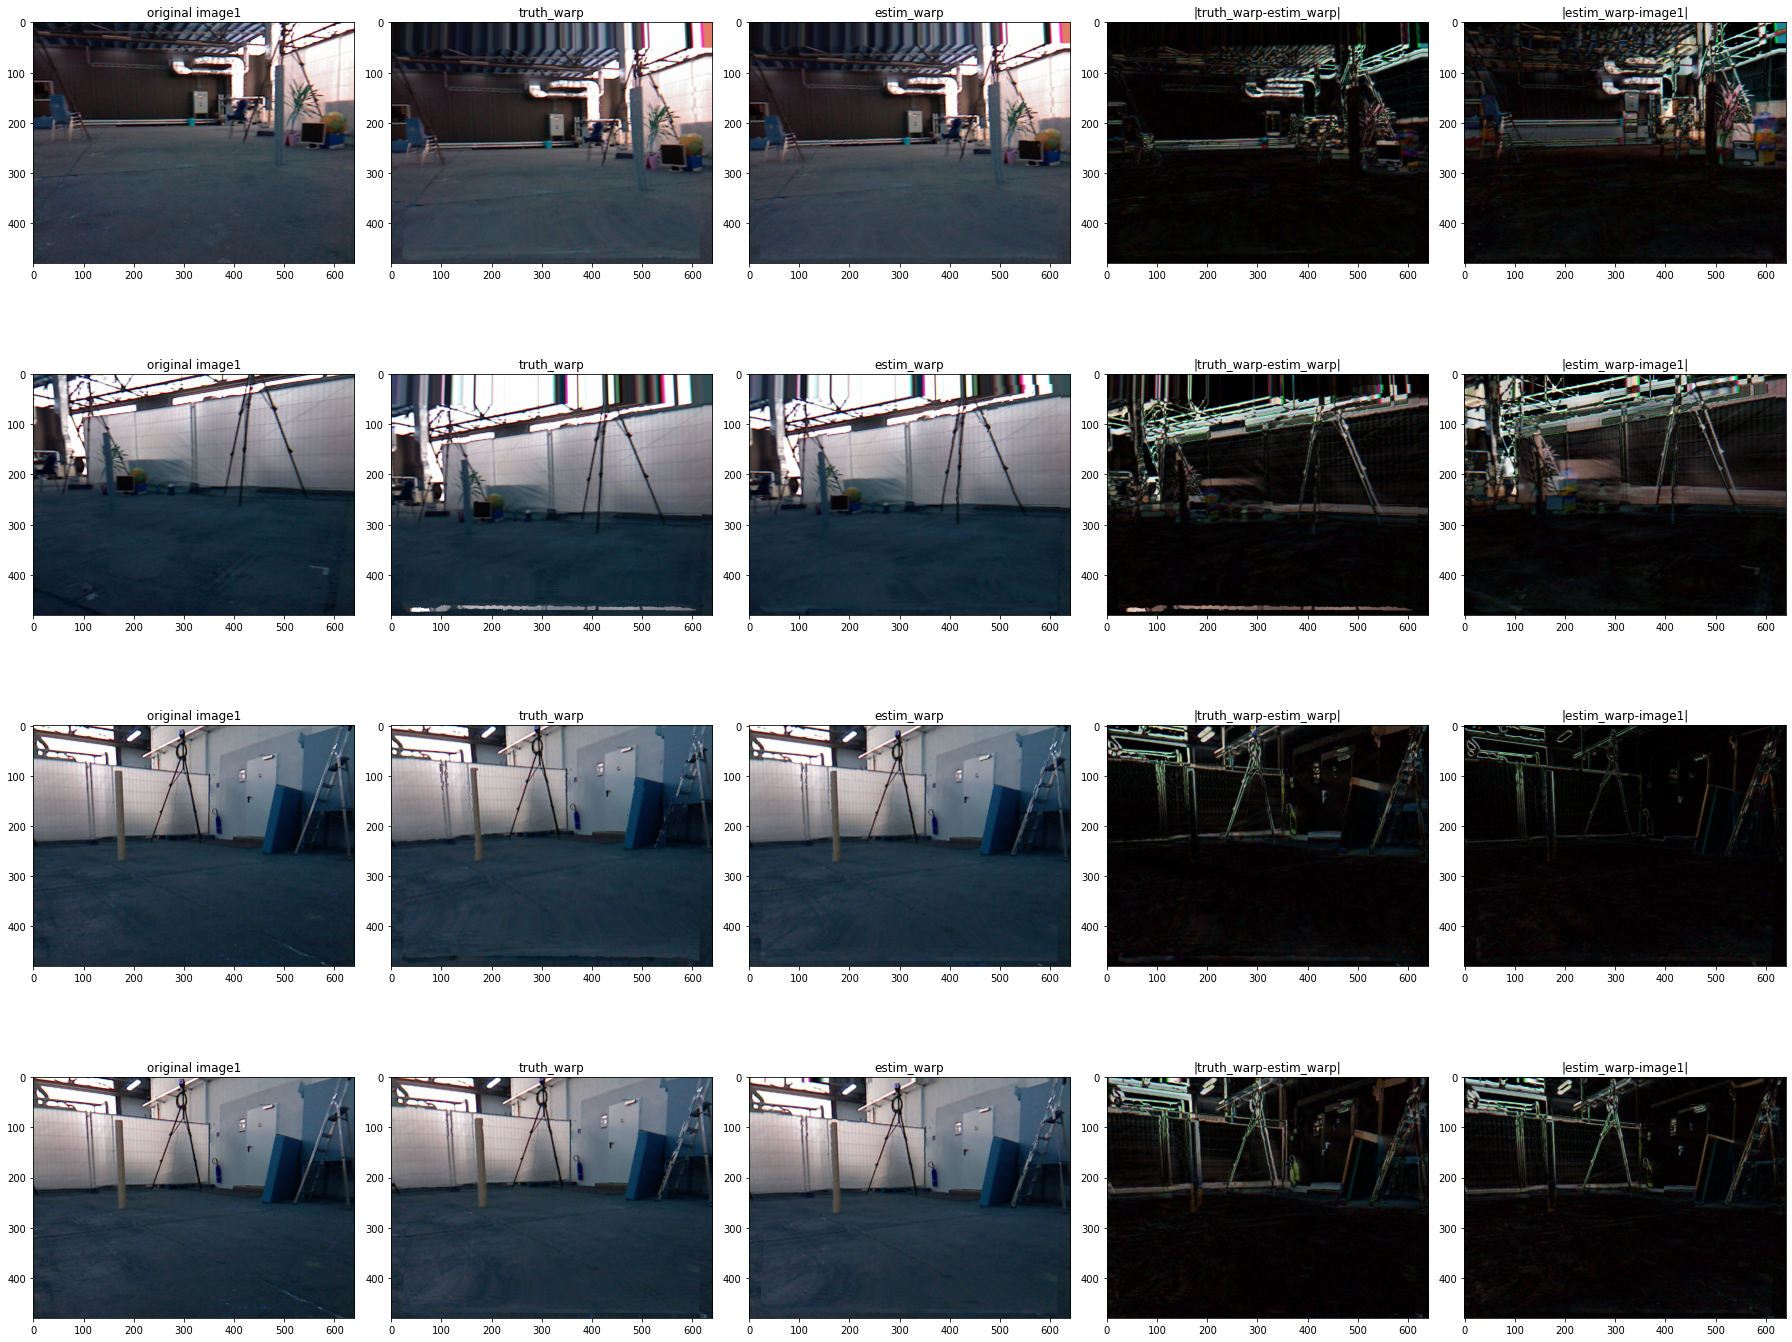

In [38]:
# Let's visualize some predictions

# pick some random batches
m = 4
pick_batch = np.random.choice(np.arange(0,14,1),size=m,replace=True)
pick_image = np.random.choice(np.arange(0,16,1),size=m,replace=True)

plt.figure(figsize=(25,m*5))

for i in range(m):
  plt.subplot(m,5,i*5+1)
  image1 = validation_generator_warp[pick_batch[i]][0][0][pick_image[i]]
  plt.imshow(image1)
  plt.title('original image1')
  plt.subplot(m,5,i*5+2)
  truth_warp = validation_generator_warp[pick_batch[i]][1][0][pick_image[i]]
  plt.imshow(truth_warp)
  plt.title('truth_warp')
  plt.subplot(m,5,i*5+3)
  estim_warp = model.predict(validation_generator_warp[pick_batch[i]])[pick_image[i]]
  plt.imshow(estim_warp)
  plt.title('estim_warp')
  plt.subplot(m,5,i*5+4)
  plt.imshow(np.abs(truth_warp-estim_warp))
  plt.title('|truth_warp-estim_warp|')
  plt.subplot(m,5,i*5+5)
  plt.imshow(np.abs(estim_warp-image1))
  plt.title('|estim_warp-image1|')
plt.tight_layout()
plt.show()

In [ ]:
# this keeps the weights from model, already trained
htm_model = tf.keras.models.Model(inputs=[input_A,depth_A,input_B,depth_B],outputs=[exp_xi])

_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
htm_model.compile(optimizer=_optimizer, loss ='mse')# metrics = metric_mean)

In [ ]:
htm_val_preds = htm_model.predict(validation_generator)
htm_train_preds = htm_model.predict(training_generator)

In [ ]:
print(htm_val_preds)

[[[ 9.9998462e-01 -4.5788279e-03  3.1358358e-03  9.6601974e-03]
  [ 4.5634061e-03  9.9997759e-01  4.9077538e-03 -1.5085186e-02]
  [-3.1582371e-03 -4.8933681e-03  9.9998301e-01  2.1854140e-02]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[ 9.9999392e-01  3.4602145e-03 -4.4377995e-04  2.3009402e-03]
  [-3.4590981e-03  9.9999094e-01  2.4929997e-03 -2.0733289e-02]
  [ 4.5240228e-04 -2.4914495e-03  9.9999684e-01  2.0330694e-02]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[ 9.9999595e-01  2.6745363e-03 -9.5098332e-04  2.7738512e-03]
  [-2.6722150e-03  9.9999344e-01  2.4338497e-03 -1.8952802e-02]
  [ 9.5748657e-04 -2.4312986e-03  9.9999654e-01  2.0022437e-02]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 ...

 [[ 9.9999088e-01  4.1554645e-03 -9.5579296e-04  1.4897973e-03]
  [-4.1530281e-03  9.9998814e-01  2.5364966e-03 -2.0022128e-02]
  [ 9.6632191e-04 -2.5325043e-03  9.9999630e-01  1.9935537e-02]
  [ 0.0000000e+00  0.0000000

In [ ]:
# let's make a new data generator that gives the HTMs as labels
class DataGeneratorHTM(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, custom_indices, batch_size=32,
                  shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.direct = "./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/"
        self.indexes = custom_indices
        self.save_indices = custom_indices
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        index = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Find list of IDs
        # Generate data
        X, y = self.__data_generation(index)#batch)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = self.save_indices #np.arange(len(self.list_IDs)-5)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, names_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        x1_full = np.empty((0, 480, 640, 4))
        x2_full = np.empty((0, 480, 640, 4))
        y_full = np.empty((0, 4, 4))
        for name in names_temp:
          # Small hack due to off-by-one in the inidices
          x1 = np.load(self.direct+"/images/rgbd_%d.npy"%int(self.list_IDs[int(name[0])][0]))
          #print("%d, %d" %(int(self.list_IDs[int(name[0])][0]), int(self.list_IDs[int(name[0])+4][0])))
          x1 = np.reshape(x1,(1,480, 640, 4))
          x2 = np.load(self.direct+"images/rgbd_%d.npy"%int(self.list_IDs[int(name[0])+4][0]))
          x2 = np.reshape(x2,(1,480, 640, 4))
          x1 = x1/255.
          #x1 = x1 - np.mean(x1, axis=0)
          x2 = x2/255.
          #x2 = x2 - np.mean(x2, axis=0)
          depth1 = x1[0,:,:,3]*5.
          depth1 = np.where(depth1==0,10.,depth1)
          depth2 = x2[0,:,:,3]*5
          depth2 = np.where(depth2==0,10.,depth2)
          x1[0,:,:,3] = depth1
          x2[0,:,:,3] = depth2
          y1 = np.load(self.direct+"pose/htm_%d.npy"%int(self.list_IDs[int(name[0])][0]))
          y2 = np.load(self.direct+"pose/htm_%d.npy"%int(self.list_IDs[int(name[0])+4][0]))
          #y = np.linalg.inv(y1).dot(y2) # Use this if the poses are camera in world frame
          y = y1.dot(np.linalg.inv(y2)) # Use this if the poses are world in camera frame
          x1_full = np.concatenate((x1_full, x1))
          x2_full = np.concatenate((x2_full, x2))
          y_full = np.concatenate((y_full, np.reshape(y, (1, 4, 4)) ))
        #y_quat = tfg_transformation.quaternion.from_rotation_matrix(y_full[:,0:3, 0:3])
        #y_quat = np.arccos(y_quat[:,3]).reshape((-1,1))*y_quat[:,0:3]/np.linalg.norm(y_quat[:,0:3], axis=1).reshape((-1,1))
        #total = tf.keras.layers.concatenate((y_quat, y_full[:,0:3,3]), dtype='float64')
        # here
        return  [x1_full[:,:,:,0:3], x1_full[:,:,:,3], x2_full[:,:,:,0:3], x2_full[:,:,:,3]],[y_full]

In [ ]:
def make_generatorHTM(indices_filename):
  with open('./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/all_frame_ids.csv', newline='') as f:
    reader = csv.reader(f)
    list_IDs = list(reader)
  with open(indices_filename, newline='') as f:
    reader = csv.reader(f)
    indices = list(reader)
  indices = np.asarray(indices)
  return DataGeneratorHTM(list_IDs = list_IDs, custom_indices = indices, batch_size=16, shuffle=True )

In [ ]:
train_filename = './drive/My Drive/Machine_Learning_Projects/freiburg_dataset/training_indices.csv'
valid_filename = './drive/My Drive/Machine_Learning_Projects/freiburg_dataset/validation_indices.csv'

training_generatorHTM = make_generatorHTM(train_filename)
validation_generatorHTM = make_generatorHTM(valid_filename)

In [ ]:
htm_model.evaluate(training_generatorHTM)

69/69 [==============================] - 64s 923ms/step - loss: 7.1075e-04


0.0007107506389729679

In [ ]:
htm_model.evaluate(validation_generatorHTM)

69/69 [==============================] - 15s 220ms/step - loss: 7.3424e-04


0.0007342399912886322